# Postprocessing a DeepONet Trained for a 0D Reactor

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_10Cases/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_10Cases/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_Isobaric_10Cases/DeepONet/Deterministic/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/BayesByBackprop/Run_1/'

CasesVec      = [5] 
DirDir        = OutputDir #OutputDir #TestDir

NSamples      = 1

NVarsRed      = 5

FixedMinVal   = 1.e-14 

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/0DReact_Isobaric_10Cases/DeepONet/Deterministic/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)#, loadfile_no='000004')

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/0DReact_Isobaric_10Cases/DeepONet/Deterministic/Run_1//Training/Params//000595.h5
'load_params' took 0.036177 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/0DReact_Isobaric_10Cases/DeepONet/Deterministic/Run_1//Model/Params/Initial.h5
'save_params' took 0.059781 s

'build' took 0.655061 s



In [5]:
FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [6]:
### Evaluating on Test Data


FileName = DirDir + '/Orig/train/ext/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)

FileName   = DirDir + '/Orig/train/ext/CleanVars.csv'
Data       = pd.read_csv(FileName, header=0)
VarNamesPC = list(Data.columns)

        
        
Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

Vars0 = []
for iVars in range(1,NVarsRed+1):
    Vars0.append('PC0_'+str(iVars))
    
SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    


FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [7]:
InputVars = ['T0']+Vars0+['t']
InputVars

['T0', 'PC0_1', 'PC0_2', 'PC0_3', 'PC0_4', 'PC0_5', 't']

iVar =  16
iVarPC =  15


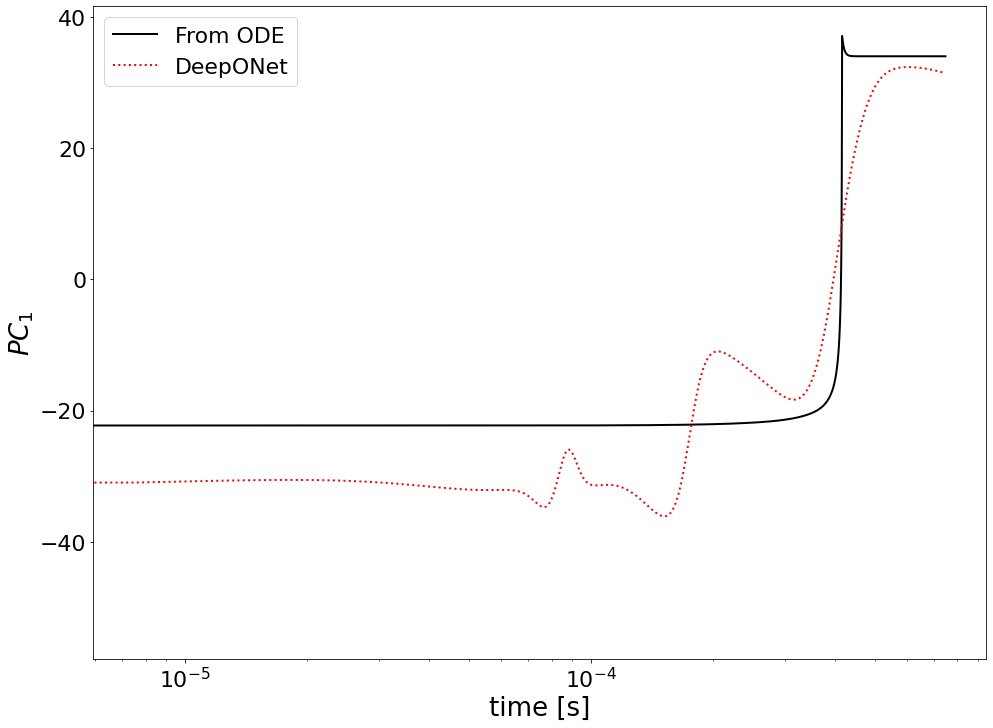

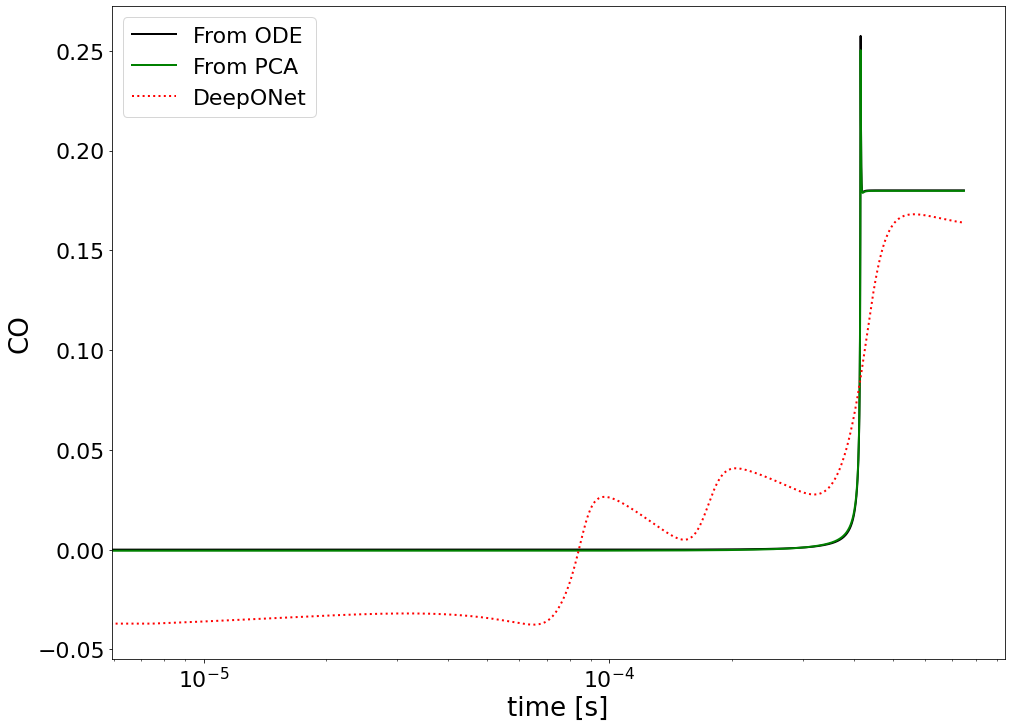

In [9]:
VarOI    = 'CO'

for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
for iVarPC in range(1,len(VarNamesPC)):
    if (VarNamesPC[iVarPC] == VarOI):
        print('iVarPC = ', iVarPC)
        break
        

iPC = 0

ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]

    
    FileName         = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
    Data             = pd.read_csv(FileName, header=0)
    tVec             = np.maximum(Data['t'].to_numpy(), FixedMinVal)

    yMatOrig_pca     = Data[Vars].to_numpy()
    yMattOrig        = (yMatOrig_pca.dot(A)) *D[:,0] + C[:,0]

    Data0            = Data[Data['t'] == 0.][Vars]
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = Vars0
    Data0['T0']      = T0Vec
    Data0['t']       = tVec
    Data0['log10(t)']= np.log10(tVec)
    Data0['log(t)']  = np.log(tVec)
    Data0.reset_index(drop=True, inplace=True)
    
    
    FileName     = DirDir + '/Orig/train/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMatOrig     = Data.to_numpy()[:,1:]
        
    
    ax[0].plot(tVec, yMatOrig_pca[:,iPC], '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, yMatOrig[:,iVar-1],  '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, yMattOrig[:,iVar-1], '-g',  label='From PCA', lw=2)
    
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
        
        yMat_pca = model.predict(Data0[InputVars])
        yMat     = (yMat_pca.dot(A))*D[:,0] + C[:,0]
    
        ax[0].plot(tVec, yMat_pca[:,iPC], ':r', label='DeepONet', lw=2)
        ax[1].plot(tVec,  yMat[:,iVar-1], ':r', label='DeepONet', lw=2)
        
    else:
        
        ### Sampling NN
        yMat_pca_sum = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_pca_sqr = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_sum     = np.zeros((yMatOrig.shape[0], A.shape[1]))
        yMat_sqr     = np.zeros((yMatOrig.shape[0], A.shape[1]))

        for iSample in range(NSamples):
            yMat_pca = NN.predict(InputDataTest[TestInputVars+['log10(t)']])
            
            yMat_pca_sum += yMat_pca
            yMat_pca_sqr += yMat_pca**2
            
            yMat     = (yMat_pca.dot(A))*D[:,0] + C[:,0]
        
            yMat_sum += yMat
            yMat_sqr += yMat**2
            
        yMat_pca_mean = yMat_pca_sum/NSamples
        yMat_pca_std  = np.sqrt( yMat_pca_sqr/NSamples - yMat_pca_mean**2 )
        yMat_pca_p1   = yMat_pca_mean + 1.*yMat_pca_std
        yMat_pca_m1   = yMat_pca_mean - 1.*yMat_pca_std
        yMat_pca_p2   = yMat_pca_mean + 2.*yMat_pca_std
        yMat_pca_m2   = yMat_pca_mean - 2.*yMat_pca_std
        yMat_pca_p3   = yMat_pca_mean + 3.*yMat_pca_std
        yMat_pca_m3   = yMat_pca_mean - 3.*yMat_pca_std
            

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std
    
        ax[0].plot(tVec, yMat_pca_mean[:,iPC], 'b-', label=r'DeepONet, $\mu$')
        ax[0].plot(tVec, yMat_pca_p3[:,iPC],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[0].plot(tVec, yMat_pca_m3[:,iPC],   'b:', label=r'DeepONet, $\mu-3\sigma$')

        ax[1].plot(tVec, yMat_mean[:,iVar-1],  'b-', label=r'DeepONet, $\mu$')
        ax[1].plot(tVec, yMat_p3[:,iVar-1],    'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[1].plot(tVec, yMat_m3[:,iVarPC-1],  'b:', label=r'DeepONet, $\mu-3\sigma$')
    
    
ax[0].set_xscale('log')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel(VarOI)
ax[1].legend()